# Assigment 3 - GraphSage

For this assignment, we'll go through a simple example of how to use GraphSage's algorithm in a similar fashion as [Assignment 1](https://github.com/thmosqueiro/graph-attention-net-genomics-public/blob/main/notebooks/Chapter%201%20-%20Pytorch%20Intro.ipynb). Like before, getting 10 pts in this assignment gives you 100% grade. There are two extra points you can get if you want to go above and beyond (or if you want to catch up from a previous assignment).

For more info:
* https://snap.stanford.edu/graphsage/
* https://arxiv.org/pdf/1706.02216

The original publication uses Tensorflow. PyG (Pytorch Geommetric) implements solutions for Graph NNs, and include GraphSage:
* https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GraphSAGE.html
Here's their implementation of GraphSage (which is reproduced below):
* https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/basic_gnn.html#GraphSAGE

In case you need to install pyg:

In [1]:
#!pip install torch_geometric

In [81]:
# imports
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import pylab as pl

import pandas as pd
import json
import random

In [2]:
# model definition
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

In [3]:
# dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


* **Question 1 (1 pt):** Visualize the training data using a classical dimensionality reduction technique.

In [4]:
data = dataset._data

In [5]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [39]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


import numpy as np
import pandas as pd

The first dimensionality reduction technique that comes into my mind is Principal component analysis (PCA). It is a linear dimensionality reduction method, and its visualizations usually plot the first 2 PCs on a scatterplot. 

In [11]:
features = data.x
labels = data.y

In [13]:
pca = PCA(n_components=2)
feature_pc = pca.fit_transform(features.numpy())

In [14]:
feature_pc[:5]

array([[-1.1738846 ,  0.61880785],
       [ 0.12825693,  0.3127197 ],
       [ 0.44552436,  0.7295986 ],
       [ 0.14257906, -0.35278684],
       [ 0.02145175, -0.37926725]], dtype=float32)

In [16]:
labels.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [32]:
colors = ['#FF5733', '#33FF57', '#3357FF', '#F4C542', '#B833FF', '#FF33A8', '#33FFF9']
cmap = ListedColormap(colors)

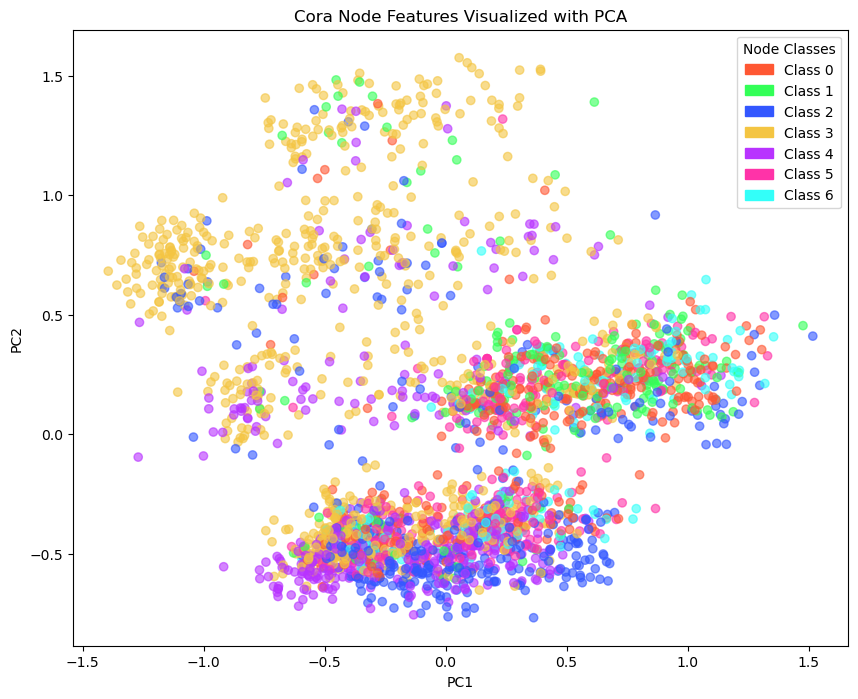

In [40]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(feature_pc[:, 0], feature_pc[:, 1], c=labels.numpy(), cmap=cmap, alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cora Node Features Visualized with PCA')

unique_labels = np.unique(labels.numpy())
legend_patches = [mpatches.Patch(color=colors[i], label=f'Class {label}') for i, label in enumerate(unique_labels)]

plt.legend(handles=legend_patches, title="Node Classes")
plt.show()

There is some visible clusters in this plot, but many points from different classes overlap with each other, suggesting that two principle components are not enought to separate and distinguish all seven classes. 

Nevertheless, there are hints of clusters where certain colors (e.g. blue dots of class 2) are more densely packed, indicating that the PCA may capture some underlying structure. 

* **Question 2 (1 pt):** What's "weight decay"?

Weight decay is a regularization technique that helps prevent overfitting. It penalizes the loss function for learning overly large weights to aid the model generalization.

In practice, weigh decay is implemented with adding a penalty term that is proportional to the squared weights to the loss function, which is often modified to be
$$L_{new} = L_{original} + \lambda \sum w^2$$

Use `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')` if you'd like to use CUDA.

In [5]:
# Setting up the model
model_sage = GraphSAGE(dataset.num_node_features, dataset.num_classes)
optimizer = torch.optim.Adam(model_sage.parameters(), lr=0.01, weight_decay=5e-4)

In [6]:
# Defining a training step
def train():
    model_sage.train()
    optimizer.zero_grad()
    out = model_sage(dataset.data)
    loss = F.nll_loss(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
    loss.backward()
    optimizer.step()

# Defining a test step
def test():
    model_sage.eval()
    with torch.no_grad():
        out = model_sage(dataset.data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask]
        acc = int(flag_is_correct.sum()) / int(dataset.data.test_mask.sum())
        return acc

In [7]:
# Run one iteration
train()
acc = test()
print(f'Accuracy: {acc:.4f}')

/home/xgui/.local/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy: 0.5020


In [9]:
# Run for a few epochs:
accuracy_sage = []
for epoch in range(100):
    train()
    accuracy_sage.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy_sage[-1]}')

Accuracy on epoch 1: 0.62
Accuracy on epoch 2: 0.647
Accuracy on epoch 3: 0.665
Accuracy on epoch 4: 0.68
Accuracy on epoch 5: 0.688
Accuracy on epoch 6: 0.688
Accuracy on epoch 7: 0.692
Accuracy on epoch 8: 0.695
Accuracy on epoch 9: 0.698
Accuracy on epoch 10: 0.695
Accuracy on epoch 11: 0.697
Accuracy on epoch 12: 0.701
Accuracy on epoch 13: 0.698
Accuracy on epoch 14: 0.697
Accuracy on epoch 15: 0.696
Accuracy on epoch 16: 0.696
Accuracy on epoch 17: 0.694
Accuracy on epoch 18: 0.696
Accuracy on epoch 19: 0.696
Accuracy on epoch 20: 0.697
Accuracy on epoch 21: 0.697
Accuracy on epoch 22: 0.696
Accuracy on epoch 23: 0.696
Accuracy on epoch 24: 0.696
Accuracy on epoch 25: 0.697
Accuracy on epoch 26: 0.699
Accuracy on epoch 27: 0.698
Accuracy on epoch 28: 0.699
Accuracy on epoch 29: 0.7
Accuracy on epoch 30: 0.702
Accuracy on epoch 31: 0.703
Accuracy on epoch 32: 0.704
Accuracy on epoch 33: 0.706
Accuracy on epoch 34: 0.707
Accuracy on epoch 35: 0.706
Accuracy on epoch 36: 0.705
Accur

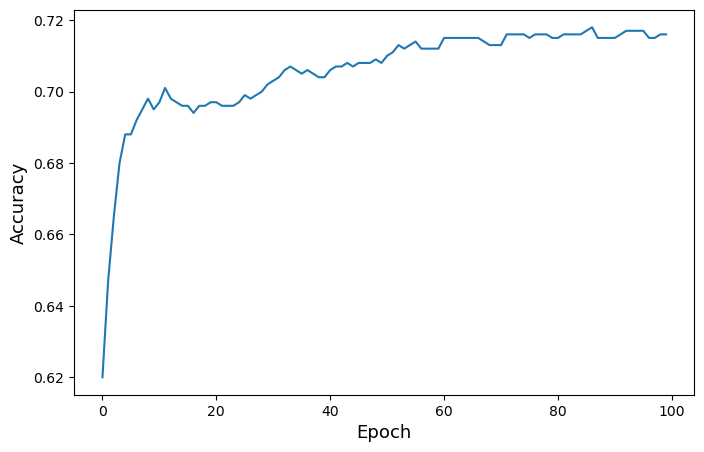

In [10]:
f, ax = pl.subplots(1, 1, figsize=(8, 5))
ax.plot(accuracy_sage, '-')
ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
pl.show()

## Questions

* **Question 3 (1 pt):** Is this model predicting all classes equally well? Demonstrate differences by using any well known way of quantifying accuracy across multiple classes.

To determine whether the model predicts all classes equally well, we can use a confusion matrix. My intuition is that the model may have a difference in performance for each class, as the PCA plot show different cluster patterns for different classes. The model's performance on class 3 may be the worst as the yellow dots of class 3 are the most sparsely distributed on the PCA scatterplot.

In [48]:
data.test_mask.sum()

tensor(1000)

In [55]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 800x800 with 0 Axes>

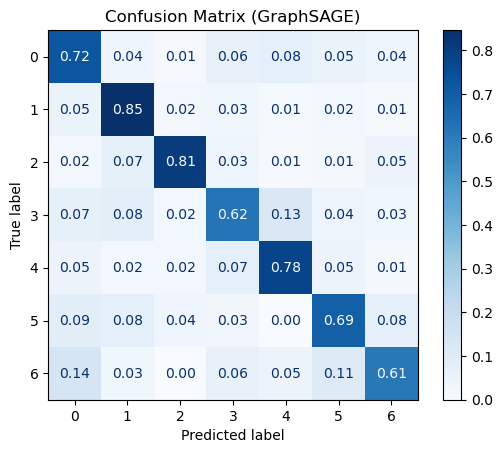

Test accuracy: 0.712


In [110]:
model_sage.eval()
with torch.no_grad():
    out = model_sage(data)
    pred = out.argmax(dim=1)

    # get only test data
    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()

    # confusion matrix
    labels = [i for i in np.unique(data.y.numpy())]
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 8))
    disp.plot(cmap='Blues', values_format='.2f')
    plt.title('Confusion Matrix (GraphSAGE)')
    plt.show()

    acc = int((y_pred == y_true).sum()) / len(y_true)
    print("Test accuracy: " + str(acc))

In [111]:
prediction_dict = {'GraphSAGE': y_pred}

In [97]:
np.unique(data.y[data.train_mask].cpu().numpy(), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([20, 20, 20, 20, 20, 20, 20]))

In [98]:
(data.train_mask).sum()

tensor(140)

In [99]:
y_true.shape

(1000,)

In [100]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [101]:
np.unique(y_true, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([130,  91, 144, 319, 149, 103,  64]))

I've selected the `normalize` attribute here so that the confusion matrix is being normalized by row, showing the proportion of correct and incorrect predictions for each class divided by the number of true labels. The numbers on the diagonal are the percentage of samples in each class that the model correctly classified. 

The overall accuracy of the model is 0.715, but the model does show a difference in ability to accurately predict each class. For class 0,1,2,4, the model performs better than average.

As demonstrated above, class 1 have the highest test accuracy of 0.85, followed by class 2 of 0.81. The model performs worst on class 6 and 3, which only have test accuracies of 0.61 and 0.62, respectively. It is worth noting that class 6 is often misclassified as class 0 and class 6 with relatively high frequencies of 0.14 and 0.11, suggesting lack or overlap of distinct features in this smallest class (with test sample size of 64).

Another interesting finding is that classes with a larger test sample size, specifically Class 3 (with test sample size of 319), also face misclassification issues, which might suggest that the small training size of 20 for each class may not be enough for the distinct features of larger classes to be sufficiently learnt.

* **Question 4 (1 pt):** Compare this GraphSage with models from Weekly Assignment 2.

_Below is the basic Node2Vec model, a random-walk based GNN._

In [11]:
import torch.nn as nn
import torch.optim as optim
from torch_geometric.utils import to_networkx
from node2vec import Node2Vec  # Importing Node2Vec for the random walk
import networkx as nx
from torch_geometric.nn import GCNConv

In [81]:
G = to_networkx(data, to_undirected=True)

# Define a simple classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

criterion = nn.CrossEntropyLoss()

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=8) 
model_node2vec = node2vec.fit(window=10, min_count=1, vector_size=64)

# Embeddings for each node
embeddings = model_node2vec.wv  # Node embeddings

# Initialize classifier and optimizer
classifier = Classifier(64, 7)
optimizer = optim.Adam(classifier.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

original_loss = []

# Training loop
for epoch in range(100):
    classifier.train()
    optimizer.zero_grad()
    
    # Get node embeddings as input
    # I've updated this section b/c I got a warning saying 
    # "Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor."
    embeddings_array = np.array([embeddings[str(i)] for i in range(data.num_nodes)])
    embeddings_tensor = torch.tensor(embeddings_array, dtype=torch.float)
    output = classifier(embeddings_tensor)
    
    loss = criterion(output, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        original_loss.append(loss.item())

print("Training complete!")

Generating walks (CPU: 8): 100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


Epoch 0, Loss: 2.748000383377075
Epoch 10, Loss: 0.9447858929634094
Epoch 20, Loss: 0.7748947739601135
Epoch 30, Loss: 0.7169734835624695
Epoch 40, Loss: 0.6929556727409363
Epoch 50, Loss: 0.6790576577186584
Epoch 60, Loss: 0.6715543866157532
Epoch 70, Loss: 0.6668456196784973
Epoch 80, Loss: 0.6634015440940857
Epoch 90, Loss: 0.6607953906059265
Training complete!


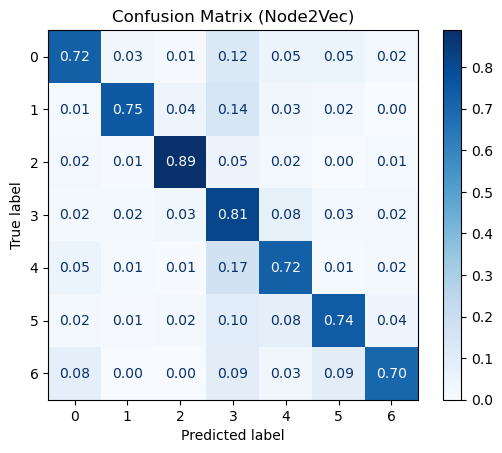

Test accuracy: 0.778


In [112]:
classifier.eval()
with torch.no_grad():
    output = classifier(embeddings_tensor)
    predictions = output.argmax(dim=1)  # Get the predicted classes
    true_labels = data.y[data.test_mask]
    pred_labels = predictions[data.test_mask]

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels.cpu(), pred_labels.cpu(), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f')
    plt.title('Confusion Matrix (Node2Vec)')
    plt.show()
    
    # Calculate accuracy
    accuracy = int((true_labels.cpu() == pred_labels.cpu()).sum()) / len(true_labels.cpu())

    print("Test accuracy: " + str(accuracy))

In [143]:
prediction_dict['Node2Vec'] = pred_labels.numpy()

_Below is the 2-layer graph convolutional network (GCN)._

In [105]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)

# Initialize model, optimizer, and loss function
model_GCN = GCN(input_dim=dataset.num_node_features, hidden_dim=16, output_dim=dataset.num_classes)
optimizer = optim.Adam(model_GCN.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

original_loss = []

# Training loop
for epoch in range(100):
    model_GCN.train()
    optimizer.zero_grad()
    
    # Forward pass
    out = model_GCN(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        original_loss.append(loss.item())

print("Training complete!")


Epoch 0, Loss: 1.9495007991790771
Epoch 10, Loss: 0.5674996376037598
Epoch 20, Loss: 0.090350441634655
Epoch 30, Loss: 0.01786245033144951
Epoch 40, Loss: 0.006633784156292677
Epoch 50, Loss: 0.0037655166815966368
Epoch 60, Loss: 0.002725268015637994
Epoch 70, Loss: 0.002218415727838874
Epoch 80, Loss: 0.001909982762299478
Epoch 90, Loss: 0.0016908693360164762
Training complete!


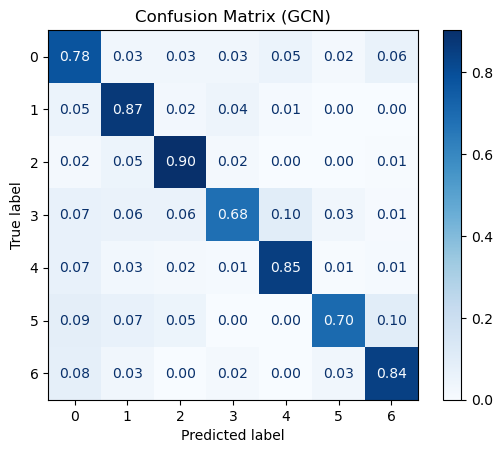

Test accuracy: 0.781


In [114]:
# Set the model to evaluation mode
model_GCN.eval()
with torch.no_grad():
    out = model_GCN(data)
    pred = out.argmax(dim=1) 
    
    true_labels_GCN = data.y[data.test_mask]
    pred_labels_GCN = pred[data.test_mask]
    
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels_GCN.cpu(), pred_labels_GCN.cpu(), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f')
    plt.title('Confusion Matrix (GCN)')
    plt.show()
    
    test_accuracy = int((pred[data.test_mask] == data.y[data.test_mask]).sum()) / int(data.test_mask.sum())
    print("Test accuracy: " + str(test_accuracy))

In [144]:
prediction_dict['GCN'] = pred_labels_GCN.numpy()

__Model Comparison__


In [145]:
overall_accuracies = [0.712, 0.778, 0.781]

In [146]:
true_labels = data.y[data.test_mask].numpy()

In [159]:
comparison_df = pd.DataFrame(columns = prediction_dict.keys())

In [160]:
comparison_df['category'] = [f'Class {str(i)}' for i in range(7)]

In [161]:
comparison_df = comparison_df.set_index('category')

In [162]:
classes = np.unique(true_labels)

In [163]:
for model in comparison_df.columns:
    pred = prediction_dict[model]

    class_accuracies = {}
    for cls in classes:
        class_mask = (true_labels == cls)

        correct_predictions = (true_labels[class_mask] == pred[class_mask]).sum()
        total_predictions = class_mask.sum()
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        class_accuracies[f'Class {str(cls)}'] = accuracy
    
    comparison_df[model] = class_accuracies

In [165]:
for model in comparison_df.columns:
    pred = prediction_dict[model]
    comparison_df.loc['Overall', model] = (true_labels == pred).mean()

In [166]:
comparison_df

,GraphSAGE,Node2Vec,GCN
category,,,
Class 0,0.723077,0.723077,0.776923
Class 1,0.846154,0.747253,0.868132
Class 2,0.805556,0.888889,0.902778
Class 3,0.623824,0.811912,0.683386
Class 4,0.778523,0.724832,0.852349
Class 5,0.689320,0.737864,0.699029
Class 6,0.609375,0.703125,0.843750
Overall,0.712000,0.778000,0.781000


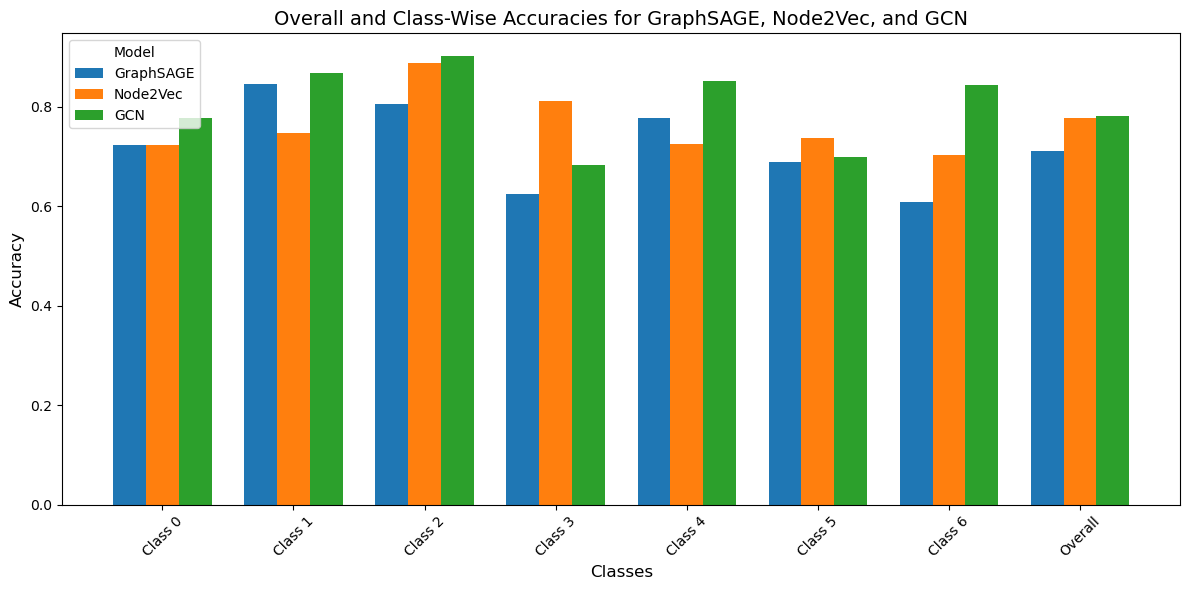

In [170]:
classes = comparison_df.index
models = comparison_df.columns

bar_width = 0.25
x = np.arange(len(classes))

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
for i, model in enumerate(models):
    accuracies = comparison_df[model]
    ax.bar(x + i * bar_width, accuracies, width=bar_width, label=model)

# Customize the plot
ax.set_xlabel('Classes', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Overall and Class-Wise Accuracies for GraphSAGE, Node2Vec, and GCN', fontsize=14)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(classes)
ax.legend(title='Model', )

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- GraphSAGE: test accuracy of 0.712, performs moderately well across most classes, but accuracy is the lowest among the three models. Test accuracy is particularly low in class 3 and 6, suggesting difficulties in distinguishing among features.
- Node2Vec: test accuracy of 0.778, higher accuracy than GraphSAGE, indicating better feature representation is learnt by this model. Class 2 and 3 are classified well with accuracies of 0.89 and 0.81. Performance is more balanced than the other two models. There is high frequencies of class 0, 1, 4 being wrongly predicted to be class 3.
- GCN: test accuracy of 0.781, highest accuracy among three models, suggesting that the convolutional approach may better suit the Cora data structure. It shows particularly high accuracies for class 1, 2, 4 and 6, and there is less confusion across classes compared to the other two models.

For the time taken to run on the cluster, it seems that GraphSAGE is least computationally intensive, while GCN is the most computationally intensive. 

* **Question 5 (2 pt):** Change the aggregation function to `max`. What's the default?

The default aggregation function for GraphSAGE is `mean`. My intuition is that the learning curve of model with `max` would be less stable, as this aggregation is more sensitive to noise where as the `mean` aggregation distributes the influence of neighbors' features evenly. 

In [12]:
class GraphSAGEmax(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels, aggr='max') # change to max

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

model_max = GraphSAGEmax(dataset.num_node_features, dataset.num_classes)
optimizer = torch.optim.Adam(model_max.parameters(), lr=0.01, weight_decay=5e-4)

In [13]:
def train():
    model_max.train()
    optimizer.zero_grad()
    out = model_max(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# Defining a test step
def test():
    model_max.eval()
    with torch.no_grad():
        out = model_max(data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[data.test_mask] == data.y[data.test_mask]
        acc = int(flag_is_correct.sum()) / int(data.test_mask.sum())
        return acc

In [15]:
# Run for a few epochs:
accuracy_sage_max = []
for epoch in range(100):
    train()
    accuracy_sage_max.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy_sage_max[-1]}')

Accuracy on epoch 1: 0.499
Accuracy on epoch 2: 0.626
Accuracy on epoch 3: 0.682
Accuracy on epoch 4: 0.699
Accuracy on epoch 5: 0.715
Accuracy on epoch 6: 0.72
Accuracy on epoch 7: 0.725
Accuracy on epoch 8: 0.724
Accuracy on epoch 9: 0.721
Accuracy on epoch 10: 0.721
Accuracy on epoch 11: 0.72
Accuracy on epoch 12: 0.715
Accuracy on epoch 13: 0.709
Accuracy on epoch 14: 0.71
Accuracy on epoch 15: 0.713
Accuracy on epoch 16: 0.709
Accuracy on epoch 17: 0.709
Accuracy on epoch 18: 0.708
Accuracy on epoch 19: 0.709
Accuracy on epoch 20: 0.711
Accuracy on epoch 21: 0.71
Accuracy on epoch 22: 0.71
Accuracy on epoch 23: 0.708
Accuracy on epoch 24: 0.707
Accuracy on epoch 25: 0.706
Accuracy on epoch 26: 0.704
Accuracy on epoch 27: 0.704
Accuracy on epoch 28: 0.703
Accuracy on epoch 29: 0.702
Accuracy on epoch 30: 0.704
Accuracy on epoch 31: 0.704
Accuracy on epoch 32: 0.702
Accuracy on epoch 33: 0.703
Accuracy on epoch 34: 0.703
Accuracy on epoch 35: 0.703
Accuracy on epoch 36: 0.702
Accura

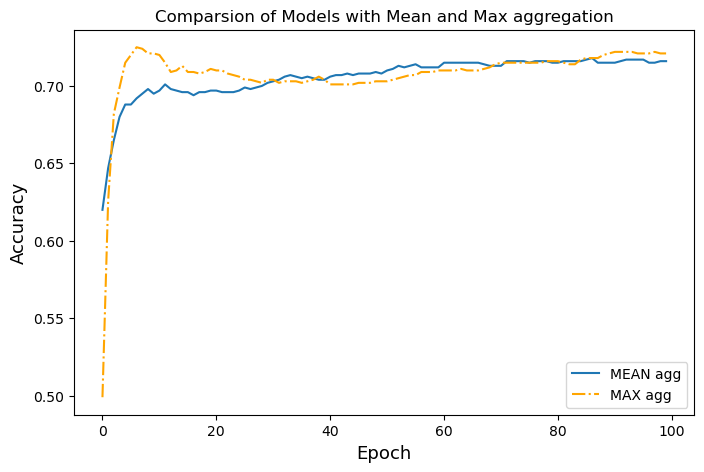

In [16]:
f, ax = pl.subplots(figsize=(8, 5))
ax.plot(accuracy_sage, '-', label='MEAN agg')
ax.plot(accuracy_sage_max, '-.', color='orange', label='MAX agg')
ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
ax.set_title('Comparsion of Models with Mean and Max aggregation')
ax.legend()
pl.show()

- The mean aggregation line shows a steady improvement in test accuracy, gradually increasing until it reaches a stable value around 0.71. It has a much more gradual learning curve at the beginning, starting with a higher accuracy in the first few epochs, which indicates slower initial convergence but more consistent improvement over time. 
- The max aggregation line has a much more quick start. Despite starting with a lower test accuracy, it quickly spikes to almost 0.73 within the first few epochs. However, it fluctuates more and stabilizes eventually close to a slightly higher accuracy in the end.

This observation matches my intuition, as the `max` aggregation emphasizes the most prominent features from neighbors and is more sensitive to large outliers. It can cause large shifts in accuracy (as observed in the beginning). On the other hand, the `mean` aggregation provides a smooth, weighted influence from all neighbors, leading to more stable updates.

* **Question 6 (2 pt):** Add one more layer to the model and investigate the performance change.

My intuition is that the performance of the model with one more layer would be better than the original one. The hidden layer may help the model to learn more subtle feature differences from the data, thus achieving a better test accuracy as time proceeds.

In [32]:
class GraphSAGE2Layer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)  
        self.conv2 = SAGEConv(hidden_channels, out_channels) 

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [33]:
model_max_2layer = GraphSAGE2Layer(dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes)
optimizer = torch.optim.Adam(model_max_2layer.parameters(), lr=0.01, weight_decay=5e-4)

In [34]:
def train_2layer():
    model_max_2layer.train()
    optimizer.zero_grad()
    out = model_max_2layer(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

def test_2layer():
    model_max_2layer.eval()
    with torch.no_grad():
        out = model_max_2layer(data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[data.test_mask] == data.y[data.test_mask]
        acc = int(flag_is_correct.sum()) / int(data.test_mask.sum())
        return acc, out

In [35]:
accuracy_sage_max_2layer = []
for epoch in range(100):
    train_2layer()
    acc, out_2layer = test_2layer()
    accuracy_sage_max_2layer.append(acc)
    print(f'Accuracy on epoch {epoch+1}: {acc}')

Accuracy on epoch 1: 0.23
Accuracy on epoch 2: 0.327
Accuracy on epoch 3: 0.395
Accuracy on epoch 4: 0.455
Accuracy on epoch 5: 0.53
Accuracy on epoch 6: 0.603
Accuracy on epoch 7: 0.66
Accuracy on epoch 8: 0.705
Accuracy on epoch 9: 0.733
Accuracy on epoch 10: 0.751
Accuracy on epoch 11: 0.76
Accuracy on epoch 12: 0.763
Accuracy on epoch 13: 0.765
Accuracy on epoch 14: 0.769
Accuracy on epoch 15: 0.769
Accuracy on epoch 16: 0.771
Accuracy on epoch 17: 0.774
Accuracy on epoch 18: 0.778
Accuracy on epoch 19: 0.777
Accuracy on epoch 20: 0.778
Accuracy on epoch 21: 0.78
Accuracy on epoch 22: 0.78
Accuracy on epoch 23: 0.78
Accuracy on epoch 24: 0.782
Accuracy on epoch 25: 0.782
Accuracy on epoch 26: 0.781
Accuracy on epoch 27: 0.783
Accuracy on epoch 28: 0.785
Accuracy on epoch 29: 0.784
Accuracy on epoch 30: 0.784
Accuracy on epoch 31: 0.783
Accuracy on epoch 32: 0.783
Accuracy on epoch 33: 0.782
Accuracy on epoch 34: 0.78
Accuracy on epoch 35: 0.779
Accuracy on epoch 36: 0.779
Accuracy 

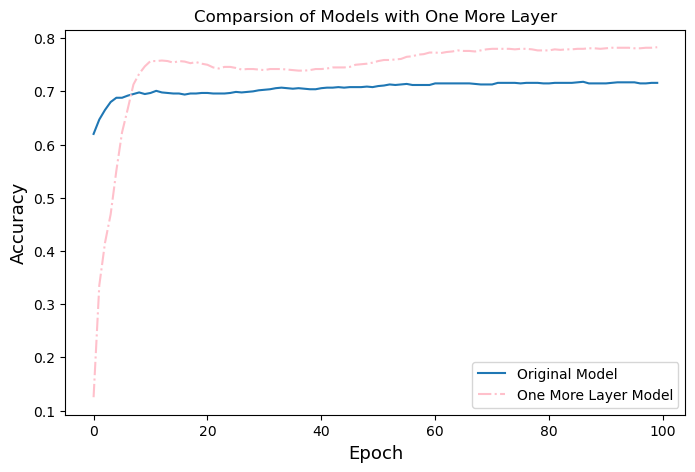

In [22]:
f, ax = pl.subplots(figsize=(8, 5))
ax.plot(accuracy_sage, '-', label='Original Model')
ax.plot(accuracy_sage_max_2layer, '-.', color='pink', label='One More Layer Model')
ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
ax.set_title('Comparsion of Models with One More Layer')
ax.legend()
pl.show()

The model with one more layer does perform better after around epoch 10. It starts from a lower initial accuracy, but rapidly converges to a higher accuracy, indicating that the additional layer enhances the model's ability to capture more complex patterns in the data and aids its prediction process. This model doesn't seem to overfit the training data as the test accuracy remains high after 100 epochs, suggesting that it generalizes well to unseen data.

* **Question 7 (2 pt):** Add drop-out to this NN and show the impact to performance. How does it change the ROC curve.

My intuition is that adding drop-out regularizes the model and prevents overfitting by deactivating random nodes during training. It would lead to better generalization and potentially a smoother ROC curve. It probably would increase the AUC which indicates a better overall performance.

In [121]:
class GraphSAGEDropout(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.25):
        super(GraphSAGEDropout, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [15]:
model_dropout = GraphSAGEDropout(dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes, dropout_rate=0.25)
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=0.01, weight_decay=5e-4)

In [16]:
def train_dropout():
    model_dropout.train()
    optimizer.zero_grad()
    out = model_dropout(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

def test_dropout():
    model_dropout.eval()
    with torch.no_grad():
        out = model_dropout(data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[data.test_mask] == data.y[data.test_mask]
        acc = int(flag_is_correct.sum()) / int(data.test_mask.sum())
        return acc, out

In [17]:
accuracy_dropout = []
for epoch in range(100):
    train_dropout()
    acc, out = test_dropout()
    accuracy_dropout.append(acc)
    print(f'Accuracy on epoch {epoch+1}: {acc}')

Accuracy on epoch 1: 0.301
Accuracy on epoch 2: 0.45
Accuracy on epoch 3: 0.479
Accuracy on epoch 4: 0.52
Accuracy on epoch 5: 0.553
Accuracy on epoch 6: 0.593
Accuracy on epoch 7: 0.656
Accuracy on epoch 8: 0.688
Accuracy on epoch 9: 0.708
Accuracy on epoch 10: 0.723
Accuracy on epoch 11: 0.738
Accuracy on epoch 12: 0.742
Accuracy on epoch 13: 0.744
Accuracy on epoch 14: 0.753
Accuracy on epoch 15: 0.761
Accuracy on epoch 16: 0.763
Accuracy on epoch 17: 0.76
Accuracy on epoch 18: 0.76
Accuracy on epoch 19: 0.762
Accuracy on epoch 20: 0.759
Accuracy on epoch 21: 0.757
Accuracy on epoch 22: 0.75
Accuracy on epoch 23: 0.748
Accuracy on epoch 24: 0.748
Accuracy on epoch 25: 0.749
Accuracy on epoch 26: 0.746
Accuracy on epoch 27: 0.747
Accuracy on epoch 28: 0.75
Accuracy on epoch 29: 0.749
Accuracy on epoch 30: 0.753
Accuracy on epoch 31: 0.755
Accuracy on epoch 32: 0.75
Accuracy on epoch 33: 0.752
Accuracy on epoch 34: 0.751
Accuracy on epoch 35: 0.749
Accuracy on epoch 36: 0.75
Accuracy 

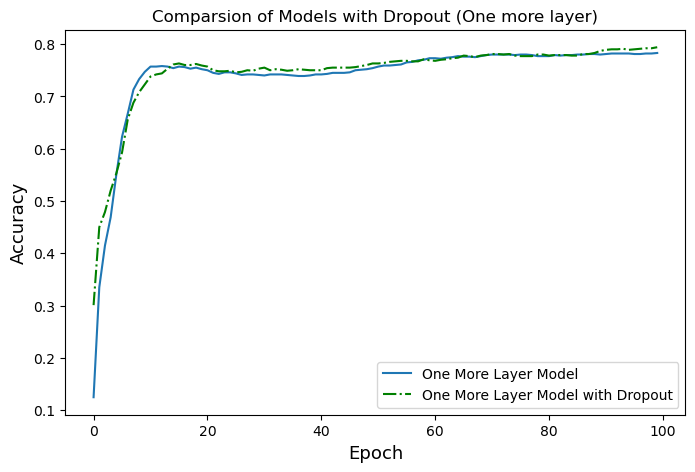

In [25]:
f, ax = pl.subplots(figsize=(8, 5))
ax.plot(accuracy_sage_max_2layer, '-', label='One More Layer Model')
ax.plot(accuracy_dropout, '-.', color='green', label='One More Layer Model with Dropout')
ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
ax.set_title('Comparsion of Models with Dropout (One more layer)')
ax.legend()
pl.show()

In terms of accuracy, the model with and without dropout have similar performance. The model with dropout is slightly more stable, suggesting dropout may help prevent minor overfitting.

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

In [40]:
# for model without dropout
true_labels = data.y[data.test_mask].cpu().numpy()
probs = torch.exp(out_2layer[data.test_mask]).cpu().numpy()

fpr = {}
tpr = {}
roc_auc = {}
for i in range(dataset.num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, probs[:, i])
    roc_auc[i] = roc_auc_score(true_labels == i, probs[:, i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(dataset.num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(dataset.num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= dataset.num_classes

macro_auc = roc_auc_score(true_labels, probs, multi_class="ovr")

In [41]:
# for model with dropout
true_labels = data.y[data.test_mask].cpu().numpy()
probs_dropout = torch.exp(out[data.test_mask]).cpu().numpy()

fpr = {}
tpr = {}
roc_auc = {}
for i in range(dataset.num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, probs_dropout[:, i])
    roc_auc[i] = roc_auc_score(true_labels == i, probs_dropout[:, i])

all_fpr_dropout = np.unique(np.concatenate([fpr[i] for i in range(dataset.num_classes)]))
mean_tpr_dropout = np.zeros_like(all_fpr_dropout)

for i in range(dataset.num_classes):
    mean_tpr_dropout += np.interp(all_fpr_dropout, fpr[i], tpr[i])

mean_tpr_dropout /= dataset.num_classes

macro_auc_dropout = roc_auc_score(true_labels, probs_dropout, multi_class="ovr")

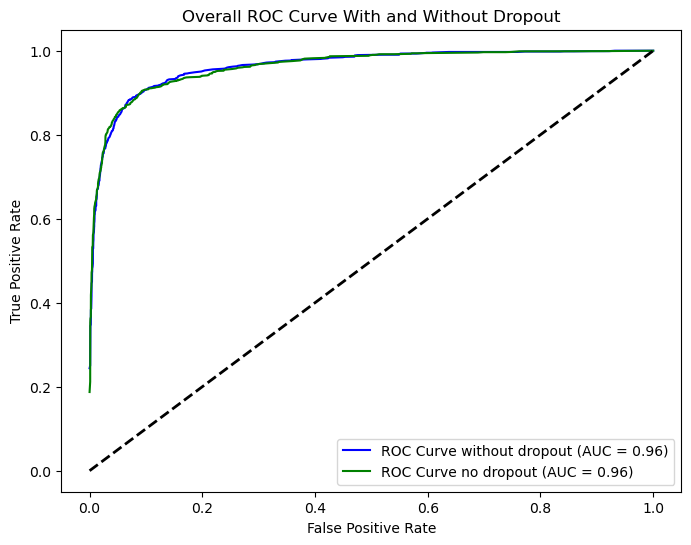

In [42]:
# Plot the Macro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(all_fpr, mean_tpr, color='blue', label=f'ROC Curve without dropout (AUC = {macro_auc:.2f})')
plt.plot(all_fpr_dropout, mean_tpr_dropout, color='green', label=f'ROC Curve no dropout (AUC = {macro_auc_dropout:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC Curve With and Without Dropout')
plt.legend(loc='lower right')
plt.show()

The overall (macro-average) ROC curve demonstrates the model's overall ability to distinguish between classes. The AUC of 0.96 of both models indicates that both models are able to accurately differentiate between the classes on average. In this case, the originial model may be generalized enough with a hidden layer, and adding dropout does not have a big difference.

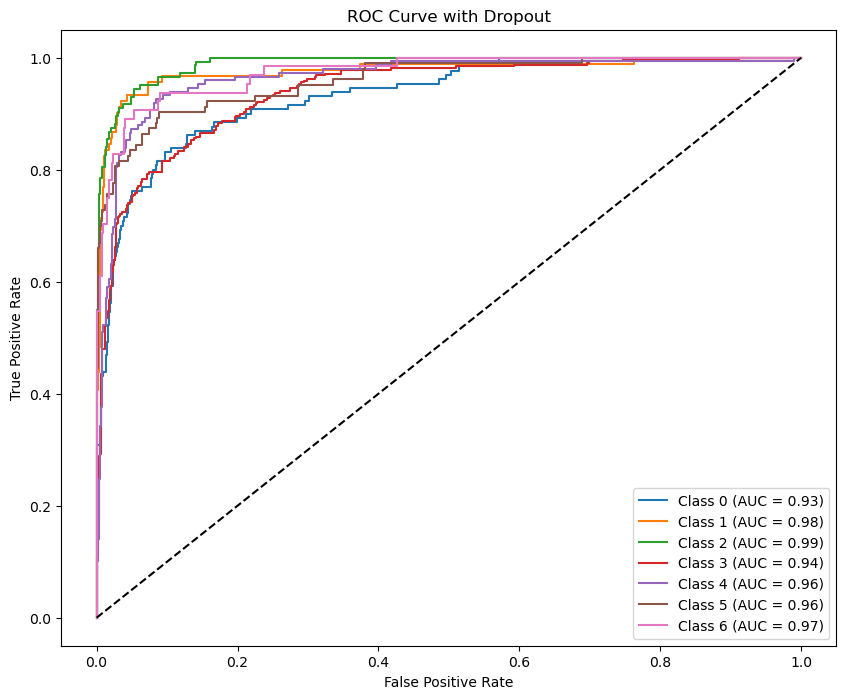

In [31]:
plt.figure(figsize=(10, 8))
for i in range(dataset.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Dropout')
plt.legend()
plt.show()

I've also plotted the ROC curves for each individual class for model with dropout. All classes have high AUCs, indivating that the model performs well across all classes. Class 2 has the highest AUC (0.99), implying that it is the easiest for the model to classify accurately.

* **Question 8 (4 pt):** Instead of using the Cora dataset, apply GraphSage to any other dataset of your choice. (UCI database)


I've found this `Facebook Large Page-Page Network` dataset from <a href='https://archive.ics.uci.edu/dataset/527/facebook+large+page+page+network'>UCI Machine Repository</a>. It contains edge, node features, and node labels, which is suitable for the usage of GraphSAGE. The labels are categories of facebook pages, like "government" or "tvshow".

In [208]:
# prepare data
edges_path = "facebook_large/musae_facebook_edges.csv"
edges_df = pd.read_csv(edges_path)

features_path = "facebook_large/musae_facebook_features.json"
with open(features_path) as f:
    features_dict = json.load(f)
features_df = pd.DataFrame.from_dict(features_dict, orient='index')

target_path = "facebook_large/musae_facebook_target.csv"
target_df = pd.read_csv(target_path)

In [209]:
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
554,2835,4518,2198,2014.0,3818.0,3045.0,4570.0,4585.0,4596.0,4599.0,...,4708.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10772,3293,2534,979,2014.0,2317.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6350,4477,2895,4039,3282.0,765.0,2669.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9218,3133,2052,979,3355.0,107.0,1878.0,1105.0,4571.0,4582.0,4593.0,...,4704.0,4713.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7787,1151,631,2613,2791.0,648.0,1684.0,3818.0,107.0,1878.0,1105.0,...,4670.0,4678.0,4695.0,4696.0,4708.0,NaN,NaN,NaN,NaN,NaN


In [210]:
features_df.index = features_df.index.astype(int)

In [211]:
features_df = features_df.sort_index()
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,3133,3825,236,874.0,1072.0,143.0,1078.0,901.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3399,597,979,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3383,3832,2035,765.0,3972.0,3364.0,663.0,2163.0,4571.0,4586.0,...,4688.0,4697.0,4713.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2710,1960,1940,4514.0,4339.0,761.0,2263.0,1340.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2873,4518,4535,1602.0,3500.0,4457.0,1910.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
features_df.shape

(22470, 31)

In [213]:
features_df.isna().sum()/features_df.shape[0]

0     0.000000
1     0.000000
2     0.000000
3     0.000445
4     0.006320
5     0.041300
6     0.136271
7     0.291277
8     0.440409
9     0.535024
10    0.577125
11    0.593146
12    0.598353
13    0.599955
14    0.600623
15    0.600712
16    0.600712
17    0.600712
18    0.600712
19    0.600846
20    0.606053
21    0.629328
22    0.694615
23    0.798620
24    0.902047
25    0.962528
26    0.987583
27    0.996573
28    0.998798
29    0.999822
30    0.999955
dtype: float64

Since there are too many missing values in most of the columns, I've decided to drop the columns that have null values over 30% and drop the nodes with null values in the remaining columns.

In [214]:
features_df = features_df.iloc[:,:8]

In [215]:
features_df.shape[0]

22470

In [216]:
nodes_to_keep = features_df.dropna().index

In [217]:
features_df = features_df.loc[nodes_to_keep]

In [220]:
target_df = target_df.loc[nodes_to_keep]

In [221]:
target_df['page_type'] = pd.Categorical(target_df['page_type'])
target_df['page_type'] = target_df['page_type'].cat.codes

In [222]:
target_df['page_type'].shape[0]

15925

In [223]:
target_df['page_type'].unique()

array([3, 0, 1, 2], dtype=int8)

In [224]:
num_nodes = target_df.shape[0]
all_indices = list(range(num_nodes))

# Randomly select 30% of the nodes for training
train_size = int(0.3 * num_nodes)
train_indices = random.sample(all_indices, train_size)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

test_mask = ~train_mask

In [225]:
train_size

4777

In [226]:
edges_df = edges_df[(edges_df['id_1'].isin(nodes_to_keep))&(edges_df['id_2'].isin(nodes_to_keep))]

In [227]:
features_df.shape

(15925, 8)

In [243]:
new_index = target_df.reset_index(drop=True).reset_index()[['index','id']]

In [244]:
mapping_dict = dict(zip(new_index['id'], new_index['index']))

edges_df.replace(mapping_dict, inplace=True)

In [246]:
# replace with new ids
edges_df.max()

id_1    15921
id_2    15924
dtype: int64

In [247]:
x = torch.tensor(features_df.values, dtype=torch.float)
edge_index = torch.tensor(edges_df.values.T, dtype=torch.long)
y = torch.tensor(target_df['page_type'], dtype=torch.long)
num_features, num_classes = features_df.shape[1], len(target_df['page_type'].unique())

In [248]:
facebook_data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask,
                    num_features=num_features, num_classes=num_classes)


In [249]:
facebook_data.num_features

8

My intuition before training is that the model's performance may be limited due to limitations in data. The data feature has been reduced to 8 due to missing values, which could lead to loss of information, particularly if the original fectures contain diverse information. It is also hard for the model to generalize well. Using the model without a hidden layer may also limit the model's capacity to learn essential information.

In [250]:
model_facebook = GraphSAGE(in_channels=facebook_data.num_features, out_channels=facebook_data.num_classes)
optimizer = torch.optim.Adam(model_facebook.parameters(), lr=0.01, weight_decay=5e-4)

In [251]:
def train_facebook():
    model_facebook.train()
    optimizer.zero_grad()
    out = model_facebook(facebook_data)
    loss = F.nll_loss(out[facebook_data.train_mask], facebook_data.y[facebook_data.train_mask])    
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [252]:
facebook_data

Data(x=[15925, 8], edge_index=[2, 76871], y=[15925], train_mask=[15925], test_mask=[15925], num_features=8, num_classes=4)

In [253]:
def test_facebook():
    model_facebook.eval()
    with torch.no_grad():
        out = model_facebook(facebook_data)
        pred = out.argmax(dim=1)
        correct = (pred[facebook_data.test_mask] == facebook_data.y[facebook_data.test_mask]).sum()
        acc = int(correct) / int(facebook_data.test_mask.sum())
        
    return acc

In [255]:
accuracy_values = []
loss_values = []

for epoch in range(100):
    loss = train_facebook()
    acc = test_facebook()

    loss_values.append(loss)
    accuracy_values.append(acc)
    
    print(f'Epoch {epoch+1}/100, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

Epoch 1/100, Loss: 809.3179, Accuracy: 0.2972
Epoch 2/100, Loss: 767.7146, Accuracy: 0.2980
Epoch 3/100, Loss: 748.3799, Accuracy: 0.2957
Epoch 4/100, Loss: 740.9387, Accuracy: 0.2954
Epoch 5/100, Loss: 732.3530, Accuracy: 0.2958
Epoch 6/100, Loss: 713.5143, Accuracy: 0.2932
Epoch 7/100, Loss: 683.4101, Accuracy: 0.2905
Epoch 8/100, Loss: 647.5880, Accuracy: 0.2906
Epoch 9/100, Loss: 615.2601, Accuracy: 0.2953
Epoch 10/100, Loss: 592.2853, Accuracy: 0.2940
Epoch 11/100, Loss: 577.3203, Accuracy: 0.2986
Epoch 12/100, Loss: 568.1585, Accuracy: 0.3020
Epoch 13/100, Loss: 558.8882, Accuracy: 0.3044
Epoch 14/100, Loss: 543.6385, Accuracy: 0.3061
Epoch 15/100, Loss: 523.0077, Accuracy: 0.3061
Epoch 16/100, Loss: 503.2354, Accuracy: 0.3010
Epoch 17/100, Loss: 489.0699, Accuracy: 0.2940
Epoch 18/100, Loss: 479.1260, Accuracy: 0.2895
Epoch 19/100, Loss: 469.6317, Accuracy: 0.2868
Epoch 20/100, Loss: 457.8509, Accuracy: 0.2914
Epoch 21/100, Loss: 442.7931, Accuracy: 0.2976
Epoch 22/100, Loss: 42

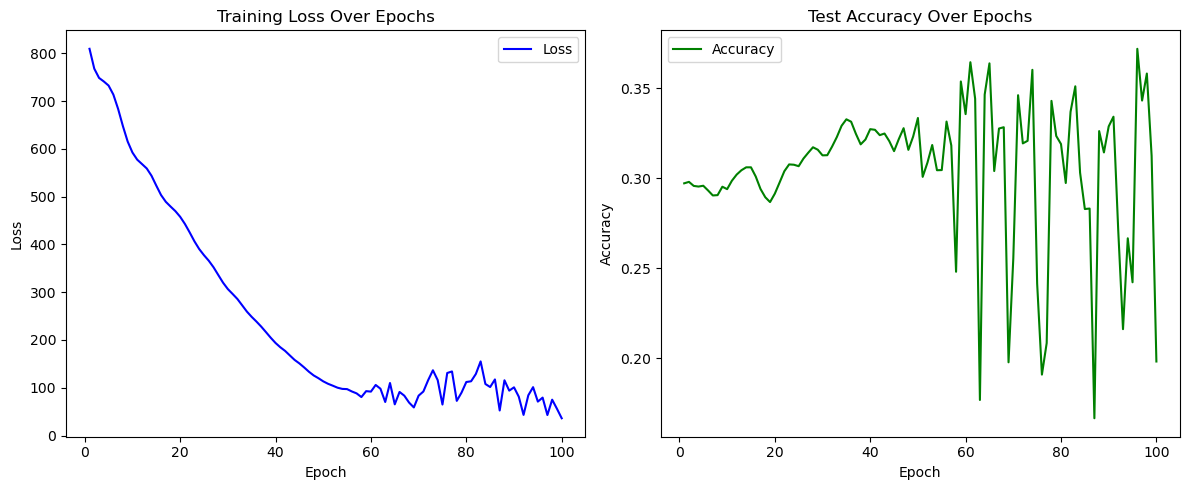

In [257]:
# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 100+1), loss_values, label='Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 100+1), accuracy_values, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

The training loss starts very high and steadily decreases with more epochs, indicating that the model is learning and minizing the loss. Similarly, the test accuracy is increasing with minor flucturation in the first 50 epochs.

However, around epoch 60, the loss and test accuracy start to fluctuate, suggesting instable training process and inconsistent performance on the test set. From the trends of the training loss, the model may be hitting some local minima and could benefit from some adjustment in hyperparameters. 

The low and fluctuating accuracy around 0.3 indicates that the model does not generalize well and may be overfitting to some extent. This suggests that the limited number of features and the lack of a hidden layer restricts the model's capacity to obtain necessary information from the data. One of my takeaways is that this data may not be suitable for GraphSAGE that doesn't take missing values.

Good luck! :)